In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-20 09:18:40.013209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 09:18:40.038095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-20 09:18:41.071650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 09:18:41.075483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 09:18:41.075601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [3]:

dataset_name = 'crypto_day'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params



Using output folder .


2023-11-20 09:18:41.117871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 09:18:41.118011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 09:18:41.118121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_day ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.5
hidden_layer_size: 10
learning_rate: 0.01
minibatch_size: 64
max_gradient_norm: 100.0
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.5
# hidden_layer_size = 10
# learning_rate = 0.01
# max_gradient_norm = 100.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_day/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_V

2023-11-20 09:18:41.714381: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:41.716665: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-20 09:18:41.921269: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_11/kernel/Assign' id:418 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_11/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_11/kernel, TemporalFusionTransformer/dense_11/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:41.934432: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape:

2023-11-20 09:18:42.384288: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/kernel/Assign' id:1428 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/kernel, TemporalFusionTransformer/time_distributed_7/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:42.469505: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_6/gamma/Assign' id:1577 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_6/gamma/Assign}} = AssignVariableOp[_has_manual_c

2023-11-20 09:18:43.069880: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:2396 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:43.165311: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_29/kernel/Assign' id:2454 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_29/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_29/kernel, TemporalFusionTransforme

2023-11-20 09:18:43.971864: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_2/reduction_indices' id:3246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_2/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:44.010864: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/cu_dnnlstm/kernel/Assign' id:3262 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/cu_dnnlstm/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/cu_dnnlstm/kernel, TemporalFusionTransformer/cu_dnnlstm/kernel/Initializer

2023-11-20 09:18:44.979266: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack' id:3908 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:45.023477: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:3909 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

2023-11-20 09:18:45.275899: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_60/bias/Assign' id:4477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_60/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_60/bias, TemporalFusionTransformer/time_distributed_60/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:45.350053: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_1' id:4551 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

                                                                                                  
 dropout (Dropout)           (None, 10)                   0         ['dense_9[0][0]']             
                                                                                                  
 dense_13 (Dense)            (None, 1, 10)                110       ['activation_2[0][0]']        
                                                                                                  
 dense_10 (Dense)            (None, 1)                    11        ['dropout[0][0]']             
                                                                                                  
 dense_11 (Dense)            (None, 1)                    11        ['dropout[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 1, 10)                0         ['dense_13[0][0]']            
          

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 3 (TensorFlowOpLayer)                                              ]                             
                                                                                                  
 dropout_2 (Dropout)         (None, 10)                   0         ['dense_17[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 31, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
          

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['layer_normalization_2[0][0]'
 Transformer/ExpandDims_1 (                                         ]                             
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10, 1)]           0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_3[0][0]']     
 12 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_7 (TimeDi  (None, 30, 10)               610       ['tf_op_layer_TemporalFusionTr
 stributed

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['time_distributed_37[0][0]', 
 Transformer/add_13 (Tensor                                          'time_distributed_38[0][0]'] 
 FlowOpLayer)                                                                                     
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice_12[0][
 20 (TensorFlowOpLayer)                                             0]']                          
                                                                                                  
 time_distributed_9 (TimeDi  (None, 30, 10)               110       ['activation_7[0][0]']        
 stributed

 istributed)                                                                                      
                                                                                                  
 time_distributed_6 (TimeDi  (None, 30, 6)                366       ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/Reshape[0][0]']     
                                                                                                  
 multiply_7 (Multiply)       (None, 30, 6)                0         ['time_distributed_10[0][0]', 
                                                                     'time_distributed_11[0][0]'] 
                                                                                                  
 time_distributed_14 (TimeD  (None, 30, 10)               110       ['dropout_7[0][0]']           
 istributed)                                                                                      
          

                                                                                                  
 multiply_15 (Multiply)      (None, 1, 1)                 0         ['time_distributed_40[0][0]', 
                                                                     'time_distributed_41[0][0]'] 
                                                                                                  
 time_distributed_44 (TimeD  (None, 1, 10)                110       ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_45 (TimeD  (None, 1, 10)                110       ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 layer_nor

 yerNormalization)                                                                                
                                                                                                  
 add_14 (Add)                (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_20[0][
                                                                    0]',                          
                                                                     'multiply_16[0][0]']         
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 1, 6)]           0         ['activation_8[0][0]']        
 Transformer/ExpandDims_2 (                                                                       
 TensorFlowOpLayer)                                                                               
          

 activation_4 (Activation)   (None, 10)                   0         ['dense_20[0][0]']            
                                                                                                  
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 1, 10)                880       ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum_2[0][0]',       
                                                                     'cu_dnnlstm[0][1]',          
                                                                     'cu_dnnlstm[0][2]']          
                                                                                                  
 dense_21 (Dense)            (None, 10)                   110       ['activation_4[0][0]']        
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 10)]             0         ['cu_dnnlstm[0][0]',          
 Transform

                                                                                                  
 add_16 (Add)                (None, 31, 10)               0         ['layer_normalization_15[0][0]
                                                                    ',                            
                                                                     'multiply_19[0][0]']         
                                                                                                  
 layer_normalization_16 (La  (None, 31, 10)               20        ['add_16[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_16[0][0]
 Transformer/Shape (TensorF                                         ']                            
 lowOpLaye

 dropout_19 (Dropout)        (None, 31, 10)               0         ['dense_82[0][0]']            
                                                                                                  
 dropout_20 (Dropout)        (None, 31, 10)               0         ['dropout_19[0][0]']          
                                                                                                  
 time_distributed_53 (TimeD  (None, 31, 10)               110       ['dropout_20[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_54 (TimeD  (None, 31, 10)               110       ['dropout_20[0][0]']          
 istributed)                                                                                      
                                                                                                  
 multiply_

2023-11-20 09:18:45.940419: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_19/beta/Assign' id:4500 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_19/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_19/beta, TemporalFusionTransformer/layer_normalization_19/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 870 samples, validate on 107 samples


2023-11-20 09:18:47.790201: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:18:48.123137: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/total_2/Assign' id:4634 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/total_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/total_2, TemporalFusionTransformer/total_2/Initializer/zeros)}}' was changed by

Epoch 1/100


2023-11-20 09:18:50.747735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 09:18:50.886948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


832/870 [===========================>..] - ETA: 0s - loss: 108.7270 - mae: 1.1054 - mse: 1.7710 - f1_metric: 0.3937

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-20 09:18:51.400360: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


870/870 [==============================] - 4s 4ms/sample - loss: 105.1777 - mae: 1.0916 - mse: 1.7382 - f1_metric: 0.3860 - val_loss: 49.7242 - val_mae: 0.7752 - val_mse: 1.1066 - val_f1_metric: 9.1270e-09
Epoch 2/100
870/870 [==============================] - 0s 329us/sample - loss: 35.5617 - mae: 0.7282 - mse: 0.8431 - f1_metric: 0.3837 - val_loss: 86.1128 - val_mae: 0.8668 - val_mse: 0.9418 - val_f1_metric: 8.5965e-09
Epoch 3/100
870/870 [==============================] - 0s 367us/sample - loss: 26.2024 - mae: 0.6904 - mse: 0.8016 - f1_metric: 0.3428 - val_loss: 58.6101 - val_mae: 0.6805 - val_mse: 0.5555 - val_f1_metric: 7.6705e-09
Epoch 4/100
870/870 [==============================] - 0s 427us/sample - loss: 22.8471 - mae: 0.6530 - mse: 0.7447 - f1_metric: 0.3798 - val_loss: 36.3698 - val_mae: 0.5283 - val_mse: 0.3363 - val_f1_metric: 7.6149e-09
Epoch 5/100
870/870 [==============================] - 0s 395us/sample - loss: 19.8152 - mae: 0.6412 - mse: 0.7365 - f1_metric: 0.3486 - 

2023-11-20 09:19:03.712099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 09:19:03.712819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 09:19:03.713218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-20 09:19:03.927055: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:19:03.933108: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_2' id:478 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mut

2023-11-20 09:19:04.392064: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:19:04.410906: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/bias/Assign' id:1433 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/bias, TemporalFusionTransformer/time_distributed_7/bias/In

2023-11-20 09:19:05.105058: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_25/bias/Assign' id:2266 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_25/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_25/bias, TemporalFusionTransformer/time_distributed_25/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:19:05.148586: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:2395 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-20 09:19:06.011025: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_45/kernel/Assign' id:3166 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_45/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_45/kernel, TemporalFusionTransformer/time_distributed_45/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:19:06.065985: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:2794 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dty

2023-11-20 09:19:06.975615: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:3919 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:19:07.022121: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_22/stack' id:3913 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_22/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

2023-11-20 09:19:07.469218: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_59/bias/Assign' id:4448 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_59/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_59/bias, TemporalFusionTransformer/time_distributed_59/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-20 09:19:07.546908: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_1' id:4551 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

                                                                    ansformer/strided_slice_2[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['dense[0][0]']               
 Transformer/stack (TensorF                                                                       
 lowOpLayer)                                                                                      
                                                                                                  
 flatten (Flatten)           (None, 10)                   0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/stack[0][0]']       
                                                                                                  
 dense_8 (

                                                                    ansformer/Sum[0][0]']         
                                                                                                  
 activation_3 (Activation)   (None, 10)                   0         ['dense_16[0][0]']            
                                                                                                  
 dense_17 (Dense)            (None, 10)                   110       ['activation_3[0][0]']        
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 4 (TensorFlowOpLayer)                                              ]                             
                                                                                                  
 tf_op_lay

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 10, 1)]          0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_1[0][0]']     
 11 (TensorFlowOpLayer)                                                                           
                                                                                                  
 add_2 (Add)                 (None, 10)                   0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_3[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 10, 6)]          0         ['tf_op_layer_TemporalFusionTr
 Transform

                                                                    ansformer/add_6[0][0]']       
                                                                                                  
 time_distributed_12 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_14[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_16 (TimeD  (None, 30, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_15[0][
                                                                    0]']                          
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_11 (TimeD  (None, 30, 6)                66        ['dropout_6[0][0]']           
 istributed)                                                                                      
                                                                                                  
 dropout_7 (Dropout)         (None, 30, 10)               0         ['time_distributed_13[0][0]'] 
                                                                                                  
 dropout_8 (Dropout)         (None, 30, 10)               0         ['time_distributed_17[0][0]'] 
                                                                                                  
 dropout_9 (Dropout)         (None, 30, 10)               0         ['time_distributed_21[0][0]'] 
                                                                                                  
 dropout_1

                                                                                                  
 multiply_8 (Multiply)       (None, 30, 10)               0         ['time_distributed_14[0][0]', 
                                                                     'time_distributed_15[0][0]'] 
                                                                                                  
 multiply_9 (Multiply)       (None, 30, 10)               0         ['time_distributed_18[0][0]', 
                                                                     'time_distributed_19[0][0]'] 
                                                                                                  
 multiply_10 (Multiply)      (None, 30, 10)               0         ['time_distributed_22[0][0]', 
                                                                     'time_distributed_23[0][0]'] 
                                                                                                  
 multiply_

                                                                                                  
 layer_normalization_8 (Lay  (None, 30, 10)               20        ['add_8[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_9 (Lay  (None, 30, 10)               20        ['add_9[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_10 (La  (None, 30, 10)               20        ['add_10[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_nor

                                                                                                  
 layer_normalization_4 (Lay  (None, 10)                   20        ['add_4[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_5 (Lay  (None, 10)                   20        ['add_5[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 multiply_17 (Multiply)      (None, 1, 10, 1)             0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims_4[0][0]',
                                                                     'tf_op_layer_TemporalFusionTr
          

 istributed)                                                        ']                            
                                                                                                  
 time_distributed_49 (TimeD  (None, 1, 10)                100       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/ExpandDims_5[0][0]']
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 10)]             0         ['time_distributed_48[0][0]', 
 Transformer/add_16 (Tensor                                          'time_distributed_49[0][0]'] 
 FlowOpLayer)                                                                                     
                                                                                                  
 activation_18 (Activation)  (None, 31, 10)               0         ['tf_op_layer_TemporalFusionTr
          

 FlowOpLayer)                                                                                     
                                                                                                  
 lambda (Lambda)             (None, 31, 31)               0         ['dense_80[0][0]',            
                                                                     'dense_81[0][0]']            
                                                                                                  
 lambda_1 (Lambda)           (None, 31, 31)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Cumsum[0][0]']      
                                                                                                  
 add_17 (Add)                (None, 31, 31)               0         ['lambda[0][0]',              
                                                                     'lambda_1[0][0]']            
          

                                                                                                  
 layer_normalization_19 (La  (None, 31, 10)               20        ['add_20[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 10)]              0         ['layer_normalization_19[0][0]
 Transformer/strided_slice_                                         ']                            
 27 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_61 (TimeD  (None, 1, 3)                 33        ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_27[0][
          

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day/fixed/TemporalFusionTransformer.ckpt


2023-11-20 09:19:07.972781: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/count/Assign' id:4619 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/count/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/count, TemporalFusionTransformer/count/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-20 09:19:08.284453: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-20 09:19:08.756598: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_61/Reshape_1' id:4607 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_61/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_61/dense_91/BiasAdd, TemporalFusionTransformer/time_distributed_61/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-20 09:19:09.089334
Best validation loss = 3.772660473796809
Params:
dropout_rate  =  0.5
hidden_layer_size  =  10
learning_rate  =  0.01
max_gradient_norm  =  100.0
minibatch_size  =  64
model_folder  =  ./saved_models/crypto_day/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  31
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  10
multiprocessing_workers  =  10
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INP

In [7]:
output_map

{'results': array([[[ 1.1870606 , -0.49885127,  0.22607748]],
 
        [[ 1.1803877 , -0.50537467,  0.22487642]],
 
        [[ 1.1431351 , -0.5444757 ,  0.21701564]],
 
        [[ 1.1433058 , -0.5439163 ,  0.21728347]],
 
        [[ 1.142269  , -0.5447191 ,  0.21728285]],
 
        [[ 1.1196916 , -0.5677415 ,  0.21281515]],
 
        [[ 1.1228642 , -0.5638744 ,  0.2136998 ]],
 
        [[ 1.116419  , -0.5699441 ,  0.21259816]],
 
        [[ 1.1265706 , -0.5586696 ,  0.21486387]],
 
        [[ 1.170188  , -0.5119513 ,  0.22413011]],
 
        [[ 1.1607538 , -0.5201512 ,  0.22267896]],
 
        [[ 1.1641164 , -0.515931  ,  0.22349428]],
 
        [[ 1.2308323 , -0.44242954,  0.23793383]],
 
        [[ 1.1978754 , -0.47733614,  0.23083042]],
 
        [[ 1.1916902 , -0.48304573,  0.22962993]],
 
        [[ 1.215109  , -0.45675838,  0.23486894]],
 
        [[ 1.1904843 , -0.48324618,  0.22962046]],
 
        [[ 1.224493  , -0.4458538 ,  0.23701268]],
 
        [[ 1.2258401 , -0.4439547 ,

In [8]:
results = output_map["results"][:, :, 1]
results = results.reshape((results.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])

targets = output_map["targets"]
targets = targets.reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,-0.498851,-0.594439
1,-0.505375,-0.594136
2,-0.544476,-0.594912
3,-0.543916,-0.617858
4,-0.544719,-0.613765
...,...,...
57,0.323698,0.123642
58,0.190847,0.119822
59,0.226592,0.174074
60,0.222432,0.172272


<Axes: >

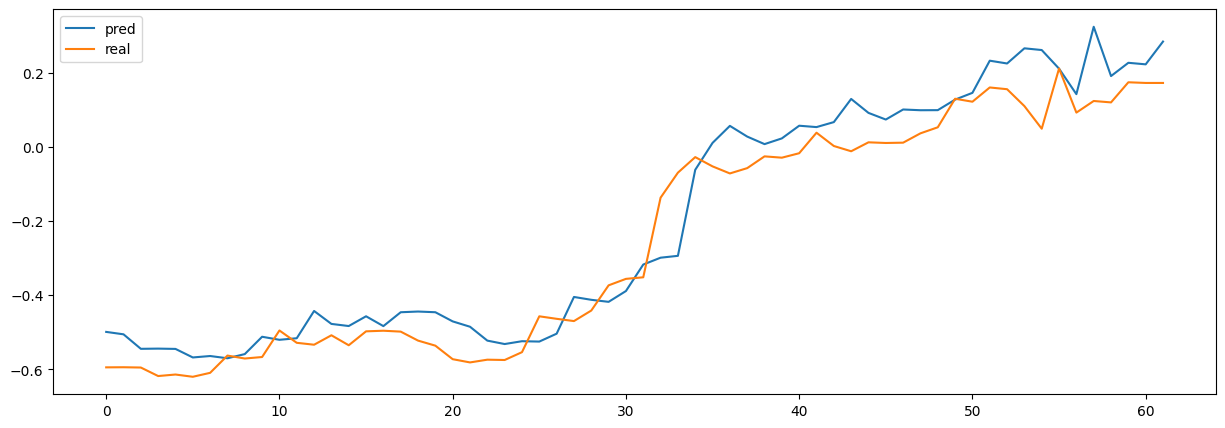

In [9]:
test_df.plot(figsize=(15,5))